In [1]:
import numpy as np
import torch
import pandas as pd
import os
import pickle
from copy import deepcopy


from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from scipy.stats import randint
from scipy.stats import uniform
from scipy.stats import loguniform


import optuna
optuna.logging.set_verbosity(0) 


import warnings
warnings.filterwarnings('ignore')

import sys
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
#plt.style.use('classic')



import npm_nnf.utils.utils_kernels as KT 
import npm_nnf.density_estimation.utils_density as utils
import npm_nnf.density_estimation.utils_data_generator as generators
import npm_nnf.utils.utils_train as utils_train
import npm_nnf.utils.utils_load as utils_load

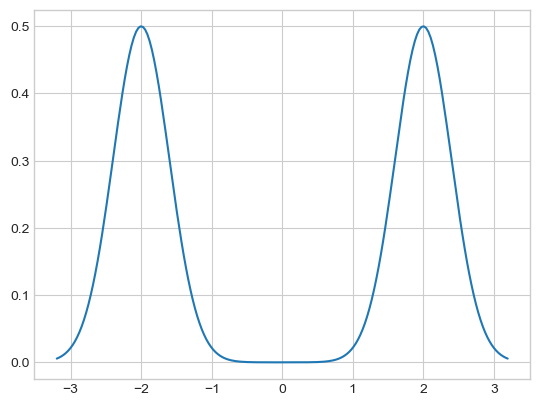

In [10]:
# Number of data points we will be using and basic parameters of the model



d = 10
#def gen(n = ndata):
#    ds,_ = generators.generateGaussianD(torch.zeros(d),1/np.sqrt(d),n,d)
#    return ds

r_data = 2
sigma_data = np.sqrt(1/(2*np.pi))
def gen(ndata):
    ds,_ = generators.generate2GaussianD(r_data,sigma_data,ndata,d)
    #ds,_ = generators.generate3GaussianD(r_data,sigma_data,0.2*sigma_data,ndata,d)
    return ds

_,density_data=generators.generate2GaussianD(r_data,sigma_data,1,d)
#_,density_data=generators.generate3GaussianD(r_data,sigma_data,0.2*sigma_data,1,d)


base = 'gaussian'
mu_base,eta_base = torch.zeros((d,)),5

ndata = 1000

In [11]:
def gentest(ntest,ctest,radtest,frac = 0.5):
    ds = torch.zeros((ntest,d))
    ntestrand = int(frac*ntest)
    ntestnear = ntest - ntestrand
    ds[:ntestrand,:] = ctest + radtest*(2*torch.rand(ntestrand,d) - 1)
    ds[ntestrand:,:],_ = generators.generate2GaussianD(r_data,sigma_data,ntestnear,d)
    #ds[ntestrand:,:],_ = generators.generate3GaussianD(r_data,sigma_data,0.2*sigma_data,ntestnear,d)
    return ds

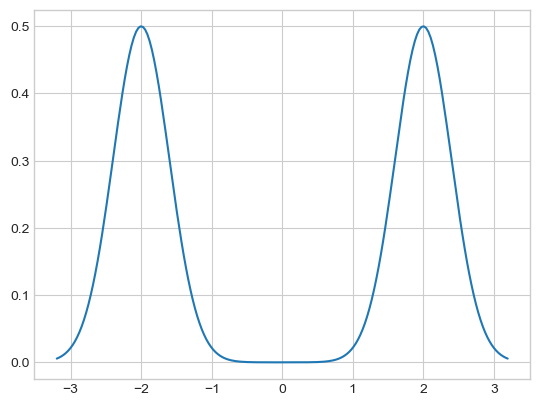

integral = 1.00039845414567
renorm size 4.2350080485841155e-11
integral = 0.9998212796773235
renorm size 4.2350080485841155e-11
tensor(0)
tensor(61905.1052)


NameError: name 'data_set' is not defined

In [12]:
#xtest = torch.linspace(-,5,3000)
c,rad,ntest = 0,4,1000
rad2 = 2


xtest2 = gentest(ntest,c,rad)
xtest = torch.zeros((ntest//2,d))


xtest[:,0] = c + rad*(2*torch.rand(ntest//2) - 1)
#xtest[:,1:] = c + rad2*(2*torch.rand((ntest//2,d-1)) - 1)

ytest = clf.predict(xtest)
ytest2 = clf.predict(xtest2)
print((ytest < 0).sum())
print(ytest.sum()*(2*rad)*(2*rad2)**(d-1)/ntest)
ydata_set = clf.predict(data_set)



xdata = clf.x_train


xhaha = torch.linspace(-rad,rad,200)
yhaha = 0.5*(torch.exp(-(xhaha-r_data)**2/(2*sigma_data**2)) +torch.exp(-(xhaha+r_data)**2/(2*sigma_data**2)) )




#xtest = torch.load(pt_path+'xtest_linear0.pt')
#ytest = torch.load(pt_path+'ytest_linear0.pt')
#xdata = torch.load(pt_path+'xdataExperiments.pt')
#ydata_set = torch.load(pt_path+'ydata_linear0.pt')


#ytestref = density_fun(xtest)



fig = plt.figure()
plt.scatter(xtest[:,0],ytest[:],lw = 1.5,label='learned projection',zorder = -1,marker = '+',color = 'b')
plt.scatter(xtest2[:,0],ytest2[:],lw = 1.5,zorder = -1,marker = '+',color = 'b')
plt.plot(xhaha,yhaha,lw = 3,linestyle = 'dashed',label = 'ground truth',color = 'orange')
#plt.plot(xtest,ytestref,linestyle = 'dashed',lw = 3,label = 'ground truth')
#plt.scatter(xdata,ydata_set,marker = '+',color = 'r',lw = 2,label = 'training points',zorder = 1)
plt.legend()
plt.xlabel("x",fontsize = 20)
plt.ylabel("p(x)",fontsize = 20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=12)
plt.ylim(-0.3,0.8)
plt.tight_layout()
fig.savefig('ourPlot0densityIMPORTANT.pdf' , format='pdf', dpi=100)
plt.show()

In [3]:
config_path = '/Users/ulyssemarteau/Desktop/NIPS/Experiments/npm_nnf/npm_nnf/density_estimation/config_our_model.json'

In [4]:
clf = utils_load.load(config_path)

In [4]:
clf.predict()

AttributeError: module 'npm_nnf.density_estimation.utils_density' has no attribute 'lmodel'

In [6]:
ytest


tensor([1.7802e-01, 1.6177e-01, 1.4539e-01, 1.4292e-01, 1.1323e-04, 1.0222e-05,
        1.9358e-01, 1.9522e-01, 1.4202e-01, 4.3339e-05, 8.3680e-02, 2.4491e-05,
        8.9164e-02, 1.6950e-01, 1.9544e-01, 8.2819e-03, 7.8001e-02, 7.7777e-02,
        9.3766e-03, 1.7127e-05, 4.4330e-04, 1.2241e-02, 1.2561e-06, 2.6973e-05,
        1.9006e-01, 2.5351e-03, 1.3090e-01, 5.5691e-02, 4.3514e-02, 1.3976e-01,
        1.2549e-06, 1.5843e-02, 3.1564e-04, 9.9860e-05, 6.8101e-03, 6.3821e-02,
        4.5669e-02, 5.8043e-04, 2.4811e-02, 5.0593e-02, 1.7284e-01, 1.8211e-01,
        9.3360e-05, 1.9085e-03, 5.0736e-03, 1.3437e-01, 9.7100e-03, 3.5846e-03,
        1.5274e-03, 3.2277e-06, 1.5899e-03, 1.2435e-05, 1.2456e-04, 7.9473e-02,
        2.8485e-02, 8.0973e-05, 3.5946e-03, 1.7515e-01, 3.1878e-02, 1.5070e-01,
        1.7076e-01, 2.2893e-05, 1.0904e-02, 1.5193e-02, 1.7090e-01, 5.1440e-02,
        1.7605e-01, 2.2272e-04, 9.1240e-02, 9.1561e-02, 1.7222e-01, 6.1445e-02,
        1.0202e-04, 8.7504e-02, 2.0008e-